In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
'''
function to calculate accuracy, precision, recall and f1 (sklearn)
y_test -> test labels, y_pred -> predicted labels
'''
def cal_accuray(y_test, y_pred):
  acc = accuracy_score(y_test, y_pred) * 100
  pres, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

  res = {'accuracy':acc, 
         'precision': pres, 
         'recall': recall, 
         'f1': f1}

  return res

'''
load data set from paths to greencsv and notgreencsv
'''
def loaddata(greencsv, notgreencsv):
  dfg = pd.read_csv(greencsv)
  dfn = pd.read_csv(notgreencsv)
  #shuffling dfn (as not all used in training dataset)
  dfn = dfn.sample(frac=1, random_state=25)
  #shuffling dfn
  data = pd.concat([dfg, dfn[0:len(dfg)]])
  data_shuff = data.sample(frac=1, random_state=25)
  
  return data_shuff

data_shuff = loaddata('/content/drive/MyDrive/binary_model/GreenPatents_Dataset.csv', '/content/drive/MyDrive/binary_model/NotGreenPatents_Dataset.csv')
data_shuff

,Abstract,GreenV
70933,utility model belongs technical field tea prod...,1
46474,invention relates nitronatrite comprehensive u...,1
194238,utility model discloses automobile used diesel...,0
32305,invention discloses treatment method extractin...,1
65748,utility model discloses kind degradable food p...,1
...,...,...
84844,gasification process divided three processes f...,0
12852,collapsible umbrella resilient rib tensioning ...,0
6618,packing method machine producing sealed packag...,1
107563,purpose opentype guardrail made timber metal p...,0


In [4]:
train_sent, test_sent, train_lab, test_lab = train_test_split(data_shuff["Abstract"].to_numpy(),
                                                              data_shuff["GreenV"].to_numpy(),
                                                              test_size=0.1, # 10% of sample in test dataset
                                                              random_state=25)
#make sure type = string & as numpy array
train_sent = [str(x) for x in train_sent]
test_sent = [str(x) for x in test_sent]
train_sent = np.array(train_sent)
test_sent = np.array(test_sent)

#average length for word in sentence
def max_lengthval(X_train):
  avlength = round(sum([len(str(i).split()) for i in X_train])/len(X_train))
  return avlength

#evaluates model
def evaluate_model(model, X_test, y_test):
  model.evaluate(X_test, y_test)
  model_pred = tf.squeeze(tf.round(model.predict(X_test)))
  result = cal_accuray(y_test, model_pred)
  print(result)
  return result

In [5]:
'''
Baseline model:

Sk-learn baseline model, bayes
Using TFID to vectorise words 
'''
# create vectorisation and model
model_base = Pipeline([
    ("tfid", TfidfVectorizer()), # vectorizer
    ("clf", MultinomialNB()) # model
])

model_base.fit(train_sent, train_lab)

model_pred = model_base.predict(test_sent)
result_b = cal_accuray(test_lab, model_pred)
print(result_b)

{'accuracy': 81.31316511612341, 'precision': 0.8152673070170774, 'recall': 0.8131316511612342, 'f1': 0.812926529411121}


In [6]:
'''
Model 1: simple dense model
Using Keras functional API (more flexible than sequential but can also use)
String (abstract) is tokenised and embedding vector is created.
'''
max_vocab_length = 10000 
# max number of words in our vocabulary - 10k words works well
# more vocabs and model performance decreases
max_length = max_lengthval(test_sent)

def create_densemodel(X_train, max_vocab_length, max_length):
  text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                      output_mode="int",
                                      output_sequence_length=max_length)

  text_vectorizer.adapt(train_sent)

  embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                              output_dim=128, # set size of embedding vector # more info gets encoded
                              embeddings_initializer="uniform", # default, intialize randomly
                              input_length=max_length, 
                              name="embedding_1") 

  inputs = tf.keras.layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
  x = text_vectorizer(inputs) # tokenise imputs
  x = embedding(x) # create embedding from tokenised inputs
  x = tf.keras.layers.GlobalAveragePooling1D()(x) # reduces dimension of embedding -> quicker computation
  outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # binary outputs, so sigmoid activation
  model = tf.keras.Model(inputs, outputs, name="model_dense") # make model
  return model

model_1 = create_densemodel(test_sent, max_vocab_length, max_length)

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


model_1_history = model_1.fit(train_sent, 
                              train_lab,
                              epochs=5, #5 epochs works well to train model
                              validation_data=(test_sent, test_lab))


Epoch 1/5
4203/4203 [==============================] - 25s 5ms/step - loss: 0.3535 - accuracy: 0.8445 - val_loss: 0.3192 - val_accuracy: 0.8567
Epoch 2/5
4203/4203 [==============================] - 22s 5ms/step - loss: 0.2955 - accuracy: 0.8721 - val_loss: 0.3213 - val_accuracy: 0.8550
Epoch 3/5
4203/4203 [==============================] - 22s 5ms/step - loss: 0.2865 - accuracy: 0.8768 - val_loss: 0.3229 - val_accuracy: 0.8553
Epoch 4/5
4203/4203 [==============================] - 22s 5ms/step - loss: 0.2821 - accuracy: 0.8791 - val_loss: 0.3240 - val_accuracy: 0.8548
Epoch 5/5
4203/4203 [==============================] - 22s 5ms/step - loss: 0.2792 - accuracy: 0.8803 - val_loss: 0.3280 - val_accuracy: 0.8544


In [7]:
'''
Model 2: Transfer learning model using universal sentence encoder with pretrained weights
'''

USE = 'https://tfhub.dev/google/universal-sentence-encoder/4'
def create_transfermodel(USE):
  sentence_embedder_layer = hub.KerasLayer(USE, 
                                          input_shape = [],
                                          dtype = tf.string, 
                                          trainable = False, #keep pretrained weights
                                          name = 'USE')
  # build sequential model with sent embedder layer
  model = tf.keras.Sequential([
      sentence_embedder_layer, 
      tf.keras.layers.Dense(100, activation='relu'), 
      #100 works well, giving slight improvement over 64, more layers do not significantly improve the model
      tf.keras.layers.Dense(1, activation='sigmoid')], #binary so sigmoid output
      name = 'model')
  return model

model_2 = create_transfermodel(USE)
# compile model
model_2.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics = ['accuracy'])
# fit model
model2_hist = model_2.fit(train_sent, train_lab, epochs=5,
                       validation_data=(test_sent, test_lab)
                       )
# again here 5 epochs enough for > 80% accuracy


Epoch 1/5
4203/4203 [==============================] - 79s 18ms/step - loss: 0.4048 - accuracy: 0.8125 - val_loss: 0.3732 - val_accuracy: 0.8318
Epoch 2/5
4203/4203 [==============================] - 69s 16ms/step - loss: 0.3605 - accuracy: 0.8369 - val_loss: 0.3577 - val_accuracy: 0.8388
Epoch 3/5
4203/4203 [==============================] - 68s 16ms/step - loss: 0.3437 - accuracy: 0.8458 - val_loss: 0.3505 - val_accuracy: 0.8434
Epoch 4/5
4203/4203 [==============================] - 66s 16ms/step - loss: 0.3313 - accuracy: 0.8520 - val_loss: 0.3455 - val_accuracy: 0.8474
Epoch 5/5
4203/4203 [==============================] - 71s 17ms/step - loss: 0.3216 - accuracy: 0.8570 - val_loss: 0.3477 - val_accuracy: 0.8413


In [8]:
"""
Same as file 'AbstractCleaner_gendataset.py' but just with single abtract inputs
"""

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def clean_abst(sent):
  all_stopwords = stopwords.words('english') #Making sure to only use English stopwords
  extra_stopwords = ['ii', 'iii', 'the']
  all_stopwords.extend(extra_stopwords)

  sent = sent.split()
  sent = [x.strip() for x in sent]
  removechars = ['[', ']', '{', '}', ';', '(', ')', ',', '.', ':', '/', '-', '#', '?', '@', '£', '$']
  for char in removechars:
      sent = list(map(lambda x: x.replace(char, ''), sent))

  sent = [x.lower() for x in sent]
  sent = [word for word in sent if word not in all_stopwords]
  sent = list(dict.fromkeys(sent))
  wonum = []
  for x in sent:
      xv = list(x)
      xv = [i.isnumeric() for i in xv]
      if True in xv:
          continue
      else:
          wonum.append(x)
  cleansent = ' '.join(wonum)

  return cleansent

'''
To predict whether patent is about green plastics or not using input abstract
'''
def predict_green(abst, model):
  abst = clean_abst(abst)
  model_pred = model.predict([abst])
  greenprob = model_pred[0]
  #print(greenprob)
  if greenprob <= 0.2:
    gV = 0
    print('Patent is not about green plastics')
  elif greenprob > 0.2 and greenprob <= 0.5:
    gV = 0
    print('Patent is likely not about green plastics')
  elif greenprob > 0.5 and greenprob <=0.75:
    gV = 0.5
    print('Not clear from abstract whether or not patent is about green plastics')
  elif greenprob > 0.75 and greenprob <=0.95:
    gV = 1
    print('Patent is likely about green plastics or either is about "green" or "plastics"')
  elif greenprob > 0.95:
    gV = 1
    print('Patent is about green plastics')
  return gV


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
result_1 = evaluate_model(model_1, test_sent, test_lab)

467/467 [==============================] - 1s 2ms/step
{'accuracy': 85.44274144970217, 'precision': 0.8554617393968962, 'recall': 0.8544274144970216, 'f1': 0.8542635291093457}


In [10]:
result_2 = evaluate_model(model_2, test_sent, test_lab)

467/467 [==============================] - 6s 12ms/step
{'accuracy': 84.13091493206612, 'precision': 0.8416512267850041, 'recall': 0.8413091493206613, 'f1': 0.8413026703649261}


In [11]:
all_results = pd.DataFrame({"Baseline": result_b, 
                            "Dense": result_1, 
                            "Transfer Learning": result_2})
all_results = all_results.transpose()    
all_results["accuracy"] = all_results["accuracy"]/100                  

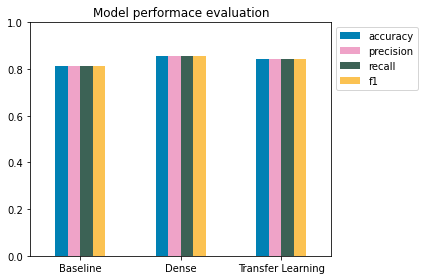

In [16]:
import matplotlib
from matplotlib import pyplot as plt
all_results.plot(kind="bar", figsize=(6, 4), color=['#0081B4', '#EFA3C8', '#3C6255', '#FBC252'])
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Model performace evaluation")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/binary_model/model_comp_eval.png', dpi=300, transparent=True)


### Testing 8 random abstracts to evaluate how well binary models work to classify patent as relating to green plastics or not.

In [53]:
abst1 = 'Shipping container comprises unitary sheet providing set external wall portions internal including first portion folded enclose volume v wherein surrounds arrangeable arrangement bounds least part second partitions define subvolumes subvolume optionally arranged move folding'
gV = predict_green(abst1, model_1)
gV = predict_green(abst1, model_2)

1/1 [==============================] - 0s 33ms/step
Not clear from abstract whether or not patent is about green plastics
1/1 [==============================] - 0s 49ms/step
Patent is likely not about green plastics


In [54]:
abst2 = 'Described herein are strength characteristics and biodegradation of articles produced using one or more “green” sustainable polymers and one or more carbohydrate-based polymers. A compatibilizer can optionally be included in the article. In some cases, the article can include a film, a bag, a bottle, a cap or lid therefore, a sheet, a box or other container, a plate, a cup, utensils, or the like.'
gV = predict_green(abst2, model_1)
gV = predict_green(abst2, model_2)

1/1 [==============================] - 0s 32ms/step
Patent is about green plastics
1/1 [==============================] - 0s 36ms/step
Patent is about green plastics


In [55]:
abst3 = 'A method of delivering a scalp cleansing composition to the scalp and a conditioning shampoo composition to the rest of the hair directed to: Applying a scalp cleansing composition directly onto the scalp using an applicator wherein the scalp cleansing composition comprises a sensate; Applying a conditioning shampoo composition on the length and ends of the hair, where length is defined as the hair starting below the root line at the back of the neck/base of the head and the ends are defined as the 4 cm of the hair furthest away from the scalp; wherein % increase scalp deposition is 10%.'
gV = predict_green(abst3, model_1)
gV = predict_green(abst3, model_2)

1/1 [==============================] - 0s 31ms/step
Patent is not about green plastics
1/1 [==============================] - 0s 40ms/step
Patent is likely not about green plastics


In [56]:
abst4 = 'Composite blends of polyester containing plastic materials, and a starch-based polymeric material that increases the biodegradability of the polyesters of such a composite in simulated or actual marine conditions (e.g., simulated by ASTM D-6691). Enhanced rate or extent of biodegradation may also be exhibited in simulated or actual land-based disposal conditions. The starch-based polymeric materials are substantially amorphous, and are homogenously blended with the polyester plastic materials. While polyester plastics such as PBAT, PLA, PCL, and/or PBS may exhibit some biodegradability characteristics when composted and/or disposed of in landfill conditions at elevated temperatures, they exhibit limited if any biodegradability when disposed of in a marine environment. Even conventional blends of starch with such polyesters do not exhibit any significant marine biodegradability with respect to the polyester components therein. Third party testing shows the present blends exhibit substantially complete biodegradability of the entire composite under marine conditions, after about 400 days.'
gV = predict_green(abst4, model_1)
gV = predict_green(abst4, model_2)

1/1 [==============================] - 0s 34ms/step
Patent is about green plastics
1/1 [==============================] - 0s 40ms/step
Patent is about green plastics


In [57]:
abst5 = 'The invention relates to a pyrolysis plant and a process for recovering (recycling) carbon fibers from carbon fiber-containing plastics, in particular from carbon fiber-reinforced plastics (CFPs or CFP materials), preferably from carbon fiber-containing and/or carbon fiber-reinforced composites (composite materials).'
gV = predict_green(abst5, model_1)
gV = predict_green(abst5, model_2)

1/1 [==============================] - 0s 37ms/step
Patent is about green plastics
1/1 [==============================] - 0s 36ms/step
Patent is about green plastics


In [58]:
abst6 = 'The present invention relates to a preparation method or a processing method for fruit food, particularly to fruit with ice cream stuff and a manufacture method thereof. The fruit of the present invention maintains the original fruit flavor, taste and shape, and has the ice cream flavor. The fruit of the present invention comprises the fruit and ice cream, wherein cavities are arranged in the fruit, and the ice cream is filled in the cavities arranged in the fruit. During the processing, first, the fruit carries out the processing of cleaning and disinfecting, the cavities are made in the fruit, and the ice cream is filled in the cavities of the fruit. The present invention provides novel fruit freezing mixed food for public, and the novel fruit freezing mixed food maintains the original flavor of various kinds of fruit (such as cherries, litchi, longan (longan), loquat, apricots, plum, peaches, grape, strawberries, bananas, etc.) and melons (such as watermelons, muskmelons, chaenomeles fruit, hami melons, etc.) and has the flavor of the ice cream.'
gV = predict_green(abst6, model_1)
gV = predict_green(abst6, model_2)

1/1 [==============================] - 0s 32ms/step
Patent is not about green plastics
1/1 [==============================] - 0s 37ms/step
Patent is not about green plastics


In [59]:
abst7 = 'GREENHOUSE GAS GRID AND TRACKING SYSTEM OF DISCLOSURE A method and computer system for reporting on a target greenhouse gas within a geographical boundary of an offset project by compiling policy parameters for the target greenhouse gas and generating a science plan for monitoring the target greenhouse gas for the target geographical boundary of the offset project, based upon the compiled policy parameters. An allometric model for the target greenhouse gas within the geographical boundary of the offset project is generated based upon the science plan of the target greenhouse gas for the geographic boundary, and a report for the target greenhouse gas within the target geographical boundary of the offset project is generated based upon the allometric model.'
gV = predict_green(abst7, model_1)
gV = predict_green(abst7, model_2)

1/1 [==============================] - 0s 33ms/step
Patent is likely about green plastics or either is about "green" or "plastics"
1/1 [==============================] - 0s 38ms/step
Not clear from abstract whether or not patent is about green plastics


In [60]:
abst8 = "Disclosed herein are a system and method that integrate vineyard sensor data into an environment that enables analysis, historical trend analytics, spatio-temporal analytics, and weather model fusion for improved decision making from vineyard management to wine production. The integration of new sensor data from multiple soil depths with surface measurements, combined with production flow process and historical information enables new decision making capabilities. A wireless network of sensor/transmitters can be distributed to provide a 3-dimensional assessment of water movement both across the grower's field and as it moves from the surface through the root zone. The soil monitoring data stream feeds into a visualization interface that will be incorporated in software based decision aid and crop management tool that helps agricultural producers reduce costs, minimize water and nutrient applications, and better protect the environment by reducing agricultural production inputs."
gV = predict_green(abst8, model_1)
gV = predict_green(abst8, model_2)

1/1 [==============================] - 0s 35ms/step
Patent is likely about green plastics or either is about "green" or "plastics"
1/1 [==============================] - 0s 38ms/step
Patent is likely about green plastics or either is about "green" or "plastics"


In [13]:
model_1.save("/content/drive/MyDrive/binary_model/densemodel")

In [64]:
model_2.save("/content/drive/MyDrive/binary_model/transferlearning_model.h5")
# need to be loaded with custom_objects={"KerasLayer": hub.KerasLayer}